In [38]:
import json
import glob
import re
import pandas as pd
import polars as pl
from os import path
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
import math

data_dir = '../out'

In [37]:
all_files = glob.glob(path.join(data_dir, "gen_*.json"))
gen_pattern = 'gen_0*([0-9]*).json$'

def extract_gen_number(filename):
    return int(re.search(gen_pattern, filename).group(1))

all_files.sort(key=extract_gen_number)

In [102]:
#
# Pure Polars way.  It's a bit wonky because of the limitations of read_json
#

import dpath.util
import io

particles = []
meta = []
for idx,file in enumerate(all_files):
    with open(file) as f:
        data = json.load(f)
        particles_bit = json.dumps([x["parameters"] for x in data["pop"]["normalised_particles"]])
        scores_bit = [x["scores"] for x in data["pop"]["normalised_particles"]]
        gen_number = extract_gen_number(file)
        
        particles.append(
            pl.read_json(io.StringIO(particles_bit)) # Complex, but should pick up multiple parameters automatically
            .with_column(pl.lit(gen_number).alias("gen_number"))
            .with_column(pl.Series("scores", scores_bit))
        )

        meta.append(pl.DataFrame()
            .with_column(pl.lit(gen_number).alias("generation"))
            .with_column(pl.lit(data["pop"]["tolerance"]).alias("tolerance"))
            .with_column(pl.lit(data["pop"]["acceptance"]).alias("acceptance"))
        )

particle_df = pl.concat(particles)
meta_df = pl.concat(meta)

print(particle_df.head(3))
print(meta_df.head(3))


shape: (3, 3)
┌──────────┬────────────┬────────────────────────┐
│ heads    ┆ gen_number ┆ scores                 │
│ ---      ┆ ---        ┆ ---                    │
│ f64      ┆ i32        ┆ list[f64]              │
╞══════════╪════════════╪════════════════════════╡
│ 0.529899 ┆ 1          ┆ [0.17, 0.25, ... 0.22] │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 0.146661 ┆ 1          ┆ [0.54, 0.54, ... 0.51] │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 0.867661 ┆ 1          ┆ [0.16, 0.22, ... 0.15] │
└──────────┴────────────┴────────────────────────┘
shape: (3, 3)
┌────────────┬────────────┬────────────┐
│ generation ┆ tolerance  ┆ acceptance │
│ ---        ┆ ---        ┆ ---        │
│ i32        ┆ f64        ┆ f64        │
╞════════════╪════════════╪════════════╡
│ 1          ┆ 1.7977e308 ┆ 1.0        │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 2          ┆ 0.451458   ┆ 0.802568   │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 3          ┆ 0.3025     ┆ 0.851789   │
└

In [13]:
#
# Pandas way
#

# particle_dfs_list = []
# meta_dfs_list = []
# for filename in all_files:
#     gen_number = extract_gen_number(filename)
    
#     with open(filename) as f:
#         data = json.load(f)
        
#     new_p_df = pd.json_normalize(data['pop'], record_path=['normalised_particles'])
#     new_p_df['generation'] = gen_number

#     meta = {
#         'generation': gen_number, 
#         'tolerance': data['pop']['tolerance'], 
#         'acceptance': data['pop']['acceptance']
#     }
#     new_m_df = pd.DataFrame(data=meta, index=[gen_number])

#     meta_dfs_list.append(new_m_df)
#     particle_dfs_list.append(new_p_df)

# particle_df = pd.concat(particle_dfs_list)
# particle_df = particle_df.reset_index()

# meta_df = pd.concat(meta_dfs_list)
# meta_df = meta_df.reset_index()
# meta_df = meta_df.drop('index', axis=1)
# meta_df['generation'] = meta_df.generation.astype('category') 

# print(meta_df.dtypes)
# print(meta_df)

# particle_df['mean_score'] = particle_df['scores'].map(mean)
# df = particle_df.drop('scores', axis=1)

generation    category
tolerance      float64
acceptance     float64
dtype: object
   generation      tolerance  acceptance
0           1  1.797693e+308    1.000000
1           2   4.514583e-01    0.802568
2           3   3.025000e-01    0.851789
3           4   2.350000e-01    0.888099
4           5   2.000000e-01    0.884173
5           6   1.700000e-01    0.874126
6           7   1.350000e-01    0.883392
7           8   1.189583e-01    0.863558
8           9   1.050000e-01    0.871840
9          10   9.500000e-02    0.869565
10         11   8.750000e-02    0.845309
11         12   8.500000e-02    0.832639
12         13   8.250000e-02    0.868810
13         14   8.500000e-02    0.859845
14         15   8.000000e-02    0.827815


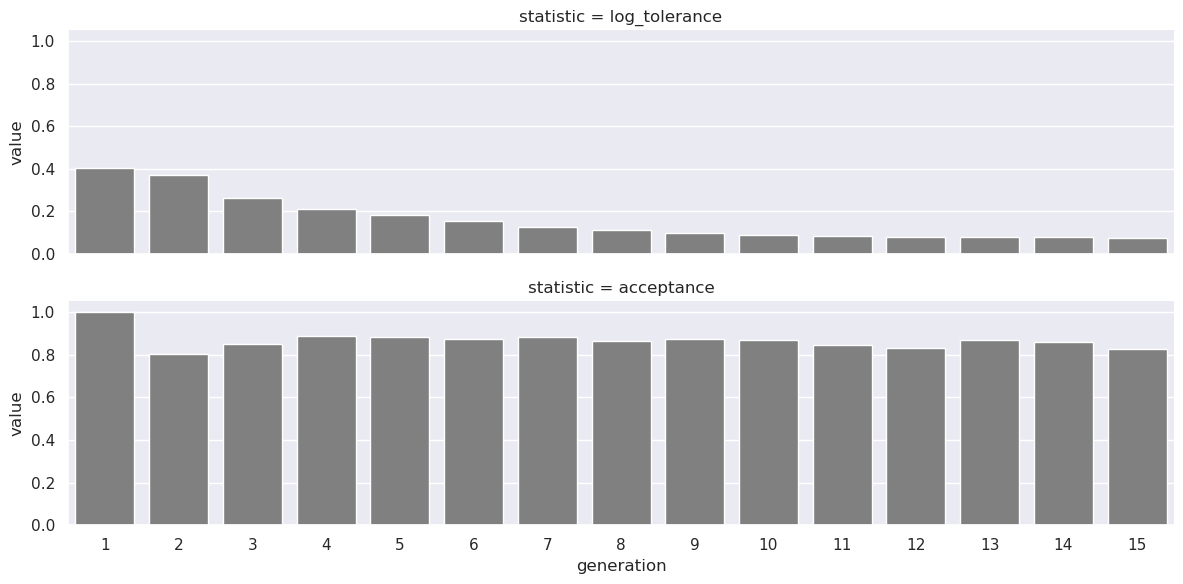

In [98]:
meta_df['log_tolerance'] = meta_df['tolerance'].apply(lambda x: math.log(1 + min(x, 0.5)))
meta_melt = meta_df.melt('generation', variable_name='statistic', value_vars=['log_tolerance', 'acceptance'])

sns.FacetGrid(
    meta_melt.to_pandas(), 
    row="statistic",
    aspect=4,
).map_dataframe(
    sns.barplot,
    x='generation', 
    y='value',
    color='grey'
)


In [76]:
meta_df.head()

generation,tolerance,acceptance,log_tolerance
i32,f64,f64,f64
1,1.7977e308,1.0,0.405465
2,0.451458,0.802568,0.372569
3,0.3025,0.851789,0.264285
4,0.235,0.888099,0.211071
5,0.2,0.884173,0.182322


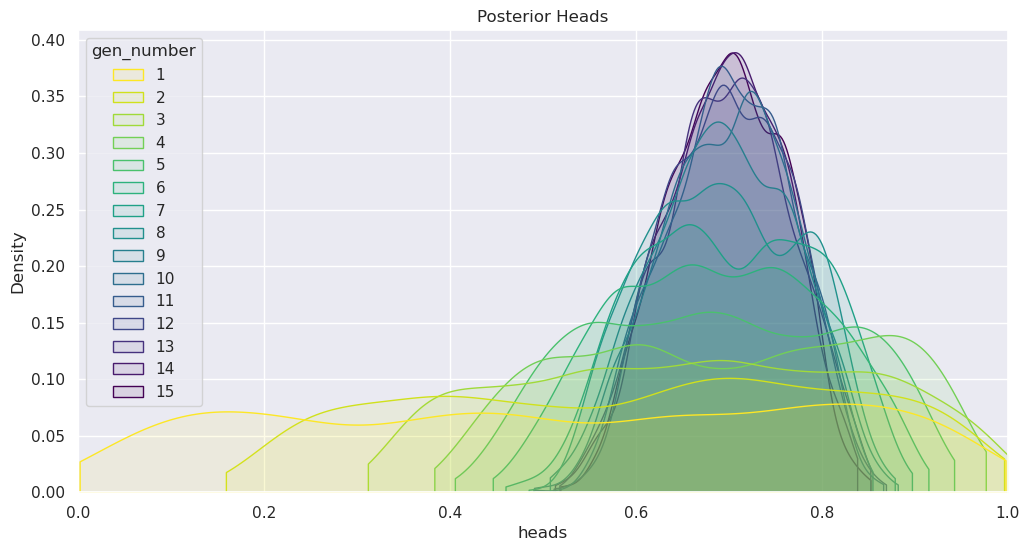

In [99]:
# sns.set_theme()
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim(0, 1)

sns.kdeplot(
   data=particle_df.to_pandas(), 
   x="heads", 
   hue='gen_number',
   fill=True, 
   palette="viridis_r",
   alpha=.1, 
   linewidth=1,
   bw_adjust=.8, 
   cut=0, 
).set(title='Posterior Heads')
sns.move_legend(ax, "upper left")

ValueError: Could not interpret value `generation` for parameter `hue`

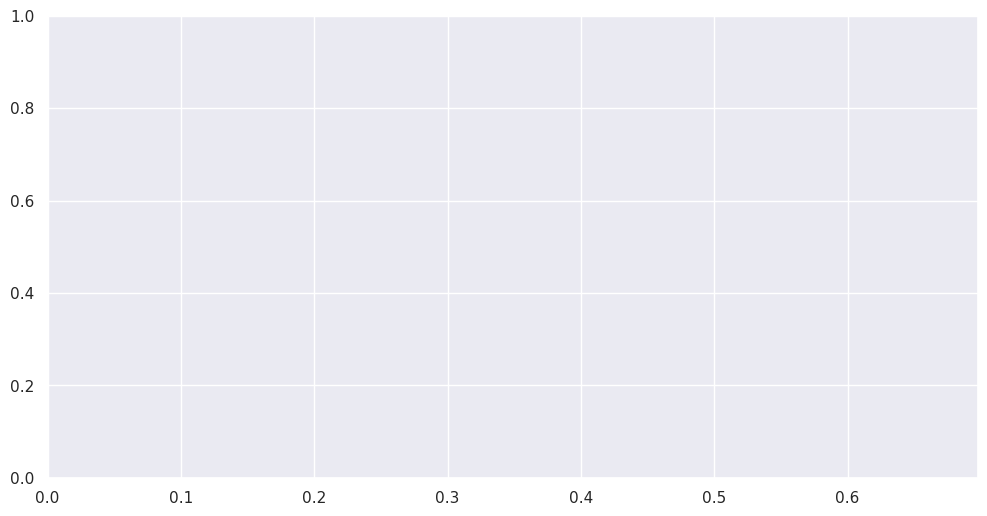

In [103]:
#sns.set_theme()

particle_df["mean_score"] = particle_df["scores"].apply(lambda l: mean(l))

fig, ax = plt.subplots(figsize=(12,6))
score_max = max(particle_df['mean_score'])
ax.set_xlim(0, score_max)
sns.kdeplot(
    data=particle_df.to_pandas(), 
    x='mean_score', 
    hue='gen_number',
    fill=True, 
    palette="rocket_r",
    alpha=.1, 
    linewidth=1,
    bw_adjust=.8, 
    cut=0,
).set(title='Mean Score Distribution')